In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import numpy as np
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import time
import math
from datetime import datetime
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


In [3]:
# 设置中文字体
plt.rcParams['font.family'] = ['Arial Unicode MS']

In [4]:
### 基础函数模块
from utils import *

In [5]:
### prophet模块
from new_prophet import prophet_obj

In [6]:
### 后处理：校准模块
from calibration import cnt_calib, ratio_calib

In [7]:
### 测试模块
from Validation import cross_validation, get_cv_stats, display_cv_result

In [8]:
### 前处理：异常检测模块
from cout_covid_dates_full import cout_covid_dates_full, cout_covid_dates

In [9]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)

In [10]:
### 画图
def plot_fcst(df_plot, city_name):
    fig = plt.figure(figsize=(8, 5))
    
    df_plot['date'] = df_plot['ds'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    df_plot = df_plot.rename(columns={'yhat':'y_pred','y':'y_true'})
    df_plot.index = df_plot['date']

    plt.plot(df_plot.index, df_plot['y_pred'], "r--", label='y_pred')
    plt.plot(df_plot.index, df_plot['y_true'], "b", label='y_true')
    plt.title('{}'.format(city_name))
    
    fig.autofmt_xdate()
    
    plt.grid("on")
    # plt.xlabel("day of month")
    # plt.ylabel('Target Var')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

### 日期设置

In [11]:
jumpoff_date = '2023-12-02'
fcst_start_date = '2023-12-03'
fcst_end_date = '2024-02-09'

### 节假日生成

In [12]:
holidays = generate_cn_holidays()
holidays.tail()

,holiday,ds,lower_window,upper_window
4,zhongqiu,2016-09-15,-1,2
5,zhongqiu,2018-09-22,-1,2
6,zhongqiu,2019-09-13,-1,2
7,zhongqiu,2021-09-19,-1,2
8,zhongqiu,2022-09-10,-1,2


### 基础数据读取

In [13]:
data = pd.read_excel('./model_data.xlsx')

In [14]:
df = data.copy()

## Prophet的日期固定命名为ds
df = df.rename(columns = {'order_date':'ds','dt':'ds',
                          'user_subsidy_rate':'subsidy_rate',
                          'total_driver_subsidy_rate':'dv_subsidy_rate',
                          'match_order_num': 'matched_order_num',
                          'city_name': 'city_type'
                         })

## 补贴率是影响单量重要的协变量
df['subsidy_rate'] = df['subsidy_rate'].fillna(0)

df['subsidy_rate_sqrt'] = df['subsidy_rate'].apply(lambda x: x**0.5)
df['subsidy_rate_square'] = df['subsidy_rate'].apply(lambda x: x**2)

In [15]:
## 以上海为例
df = df.query("city_type == '上海'")

## 以配对单预测为例
df['y'] = df['matched_order_num']

df.head()

,city_type,ds,order_num,indep_order_num,matched_order_num,match_gtv,subsidy_rate,dv_subsidy_rate,overall_subsidy_rate,subsidy_rate_sqrt,subsidy_rate_square,y
0,上海,2017-01-01,2238,1875,1662,168779.0,0.007394,0.0,0.007394,0.085990,0.000055,1662
1,上海,2017-01-02,2572,2178,1949,210213.0,0.005171,0.0,0.005171,0.071909,0.000027,1949
2,上海,2017-01-03,3643,3069,2747,307692.0,0.004186,0.0,0.004186,0.064699,0.000018,2747
3,上海,2017-01-04,4072,3369,2976,335219.0,0.004764,0.0,0.004764,0.069022,0.000023,2976
4,上海,2017-01-05,4248,3401,2875,332583.0,0.006275,0.0,0.006275,0.079216,0.000039,2875


## 1. 异常（主要是疫情）检测

In [16]:
detected_covid_dates = cout_covid_dates_full(
    df,
    detect_start_date = '2022-01-01', ## 2022年开始各地差异化疫情（2020是普遍疫情）
    cv_list = ['subsidy_rate'], ## 协变量
)

----------------------- detecting -----------------------
------ iteration 1 ------


10:09:33 - cmdstanpy - INFO - Chain [1] start processing
10:09:34 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 2 ------


10:09:37 - cmdstanpy - INFO - Chain [1] start processing
10:09:40 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 3 ------


10:09:44 - cmdstanpy - INFO - Chain [1] start processing
10:09:48 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 4 ------


10:09:51 - cmdstanpy - INFO - Chain [1] start processing
10:09:56 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 5 ------


10:10:00 - cmdstanpy - INFO - Chain [1] start processing
10:10:05 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 6 ------


10:10:10 - cmdstanpy - INFO - Chain [1] start processing
10:10:16 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 7 ------


10:10:27 - cmdstanpy - INFO - Chain [1] start processing
10:10:35 - cmdstanpy - INFO - Chain [1] done processing


------ iteration 8 ------


10:10:43 - cmdstanpy - INFO - Chain [1] start processing
10:10:52 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
detected_covid_dates

,holiday,ds,lower_window,upper_window
0,covid_0,2022-01-14,0,14
1,covid_1,2022-02-09,0,18
2,covid_2,2022-03-01,0,131
3,covid_3,2022-12-17,0,13
4,covid_4,2023-01-01,0,20
5,covid_5,2023-10-01,0,6


## 2. 测试

In [18]:
bkt_df = generate_backtest_df(
    jumpoff_date_lst = ['2023-04-01', '2023-06-01', '2023-09-01', '2023-10-01']
)
bkt_df

,jump_off_dt,fcst_stt_dt,fcst_end_dt
0,2023-04-01,2023-04-02,2023-05-01
1,2023-06-01,2023-06-02,2023-07-01
2,2023-09-01,2023-09-02,2023-10-01
3,2023-10-01,2023-10-02,2023-10-31


### 2.1 不把检测到的疫情加入节假日

Validating 4 Cutoff points
['2023-04-01', '2023-06-01', '2023-09-01', '2023-10-01']
  jump_off_date  daily_mape  pre_holiday_mape  holiday_mape  normal_mape  \
0    2023-04-01    0.414466          0.415922      0.446793     0.404477   
1    2023-06-01    0.421980          0.379712      0.776008     0.383010   
2    2023-09-01    0.713845          0.893732      0.805092     0.679953   
3    2023-10-01    0.610970               NaN      0.868010     0.559562   

   pct_monthly_error  daily_avg_pred  daily_avg_true  
0          -0.421642    31388.239547    54271.333333  
1           0.403085    75889.054171    54087.300000  
2           0.709569    93515.796350    54701.400000  
3           0.586514    79708.541871    50241.300000  

 Monthly MAPE: 0.5302

 Daily MAPE Mean: 0.54032


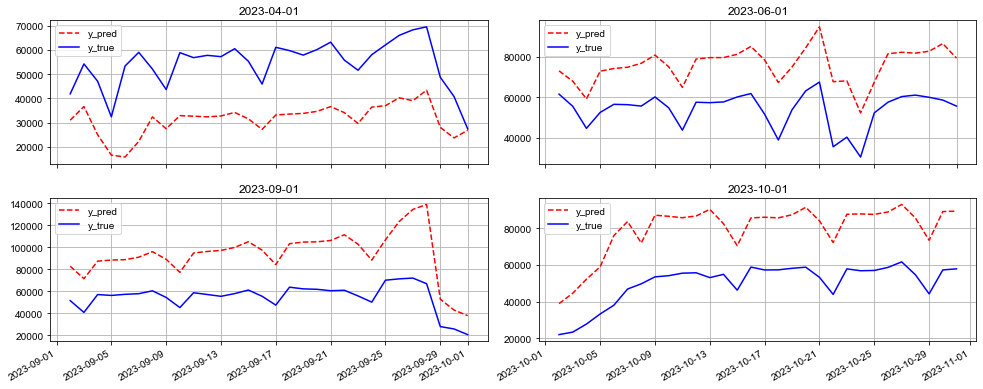

In [19]:
pm_test = prophet_obj(
    model_df = df,
    pf_params = {
        'seasonality_mode': 'additive', ## 季节模式，数量类指标如果取log就用加法，否则用乘法
        'interval_width': 0.8,
        'holidays': holidays,
        'daily_seasonality': False
    },
    default_training_start_dt = '2017-01-01', ## 视情况而定，如果早期数据噪音较大，则可考虑剔除
    default_training_end_dt = jumpoff_date, ## 对于测试来说，training_end_dt不重要
    if_log = True,
    extra_reg_lst = ['subsidy_rate']
)

### 并行运算
cv_res = cross_validation(pm_test, bkt_df, calib = None, parallel = 'processes') ## 不校正
cv_stats = get_cv_stats(cv_res)

### 作图
display_cv_result(cv_stats)

### 2.2 把检测到的疫情作为一次性节假日加入模型

Validating 4 Cutoff points
['2023-04-01', '2023-06-01', '2023-09-01', '2023-10-01']
  jump_off_date  daily_mape  pre_holiday_mape  holiday_mape  normal_mape  \
0    2023-04-01    0.092341          0.095935      0.228295     0.050836   
1    2023-06-01    0.060613          0.058344      0.206797     0.042623   
2    2023-09-01    0.084970          0.149106      0.093866     0.075841   
3    2023-10-01    0.095282               NaN      0.299783     0.054382   

   pct_monthly_error  daily_avg_pred  daily_avg_true  
0           0.010600    54846.628863    54271.333333  
1           0.009588    54605.864597    54087.300000  
2           0.078186    58978.280771    54701.400000  
3           0.074772    53997.957809    50241.300000  

 Monthly MAPE: 0.04329

 Daily MAPE Mean: 0.0833


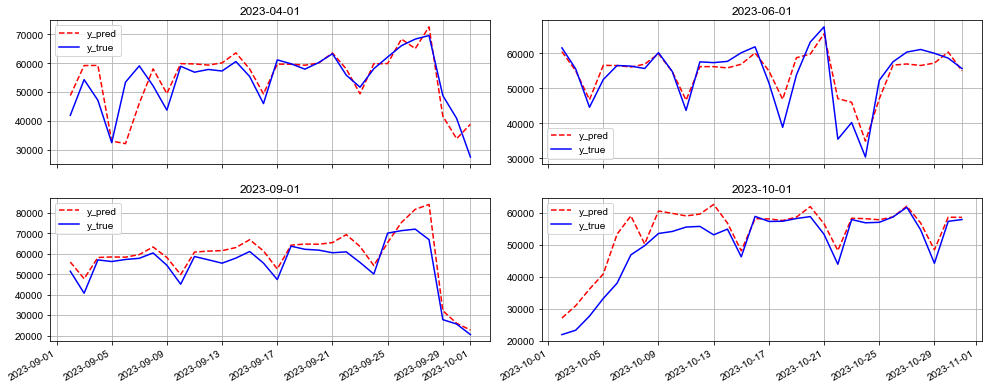

In [20]:
pm_test = prophet_obj(
    model_df = df,
    pf_params = {
        'seasonality_mode': 'additive', ## 季节模式，数量类指标如果取log就用加法，否则用乘法
        'interval_width': 0.8,
        'holidays': pd.concat([holidays, detected_covid_dates], ignore_index = True),
        'daily_seasonality': False
    },
    default_training_start_dt = '2017-01-01', ## 视情况而定，如果早期数据噪音较大，则可考虑剔除
    default_training_end_dt = jumpoff_date, ## 对于测试来说，training_end_dt不重要
    if_log = True,
    extra_reg_lst = ['subsidy_rate']
)

# calib = cnt_calib(adj_level = 'm') ### 校准方式为数量校准，校准强度为中等

### 并行运算
cv_res = cross_validation(pm_test, bkt_df, calib = None, parallel = 'processes')
cv_stats = get_cv_stats(cv_res)

### 作图
display_cv_result(cv_stats)

### 2.3. 1.把检测到的疫情加入节假日  2.校准

Validating 4 Cutoff points
['2023-04-01', '2023-06-01', '2023-09-01', '2023-10-01']
  jump_off_date  daily_mape  pre_holiday_mape  holiday_mape  normal_mape  \
0    2023-04-01    0.091970          0.094881      0.228481     0.050434   
1    2023-06-01    0.055121          0.058894      0.204384     0.035991   
2    2023-09-01    0.071331          0.135010      0.080448     0.062232   
3    2023-10-01    0.074057               NaN      0.247746     0.039319   

   pct_monthly_error  daily_avg_pred  daily_avg_true  
0           0.008813    54749.607520    54271.333333  
1           0.007569    54496.663741    54087.300000  
2           0.064960    58254.799685    54701.400000  
3           0.031744    51836.152324    50241.300000  

 Monthly MAPE: 0.02827

 Daily MAPE Mean: 0.07312


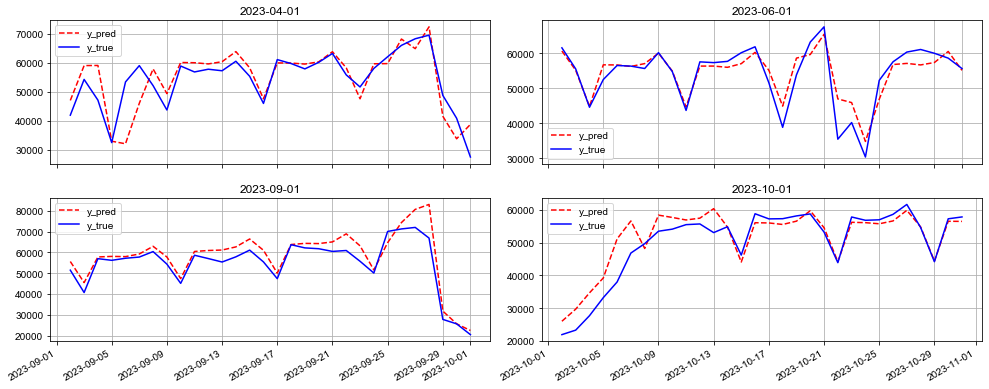

In [21]:
pm_test = prophet_obj(
    model_df = df,
    pf_params = {
        'seasonality_mode': 'additive', ## 季节模式，数量类指标如果取log就用加法，否则用乘法
        'interval_width': 0.8,
        'holidays': pd.concat([holidays, detected_covid_dates], ignore_index = True),
        'daily_seasonality': False
    },
    default_training_start_dt = '2017-01-01', ## 视情况而定，如果早期数据噪音较大，则可考虑剔除
    default_training_end_dt = jumpoff_date, ## 对于测试来说，training_end_dt不重要
    if_log = True,
    extra_reg_lst = ['subsidy_rate']
)

calib = cnt_calib(adj_level = 'm') ### 校准方式为数量校准，校准强度为中等

### 并行运算
cv_res = cross_validation(pm_test, bkt_df, calib = calib, parallel = 'processes')
cv_stats = get_cv_stats(cv_res)

### 作图
display_cv_result(cv_stats)

## 3. 预测

10:12:18 - cmdstanpy - INFO - Chain [1] start processing
10:12:25 - cmdstanpy - INFO - Chain [1] done processing


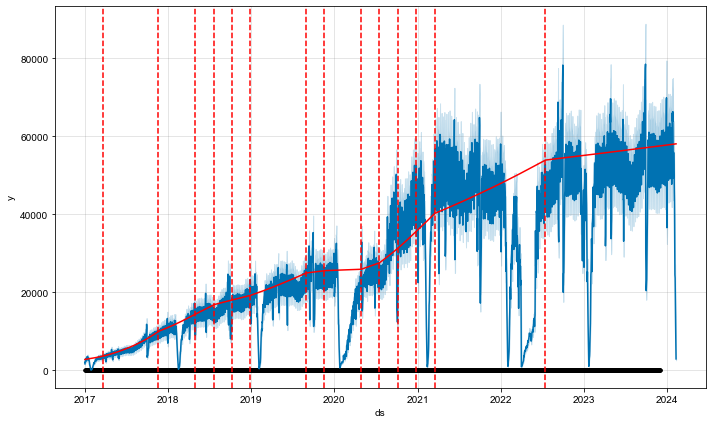

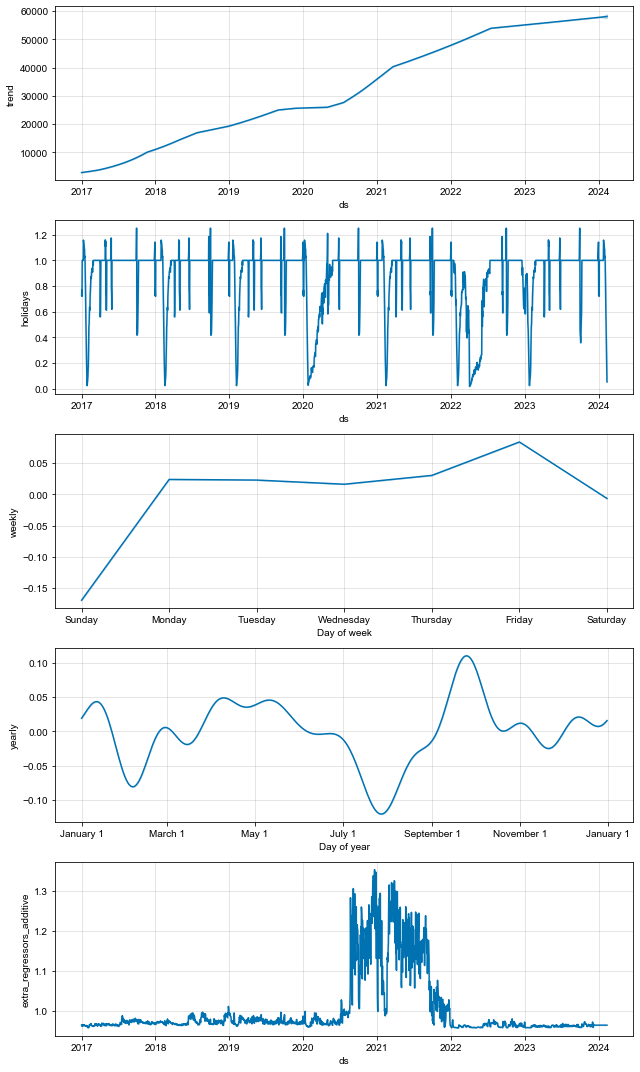

In [22]:
pm_pred = prophet_obj(
    model_df = df,
    pf_params = {
        'seasonality_mode': 'additive', ## 季节模式，数量类指标如果取log就用加法，否则用乘法
        'interval_width': 0.8,
        'holidays': pd.concat([holidays, detected_covid_dates], ignore_index = True),
        'daily_seasonality': False
    },
    default_training_start_dt = '2017-01-01', ## 视情况而定，如果早期数据噪音较大，则可考虑剔除
    default_training_end_dt = jumpoff_date, ## 对于测试来说，training_end_dt不重要
    if_log = True,
    extra_reg_lst = ['subsidy_rate']
)

### 预测
pred_df = pm_pred.predict(
    jump_off_date = jumpoff_date,
    fcst_stt_date = fcst_start_date,
    fcst_end_date = fcst_end_date,
    default_reg = 'Auto',
    if_plot = True, ## 是否将时序decompose结果打印
)

### 校正
calib = cnt_calib(adj_level = 'm') ### 校准方式为数量校准，校准强度为中等
pred_df = calib.adj_fcst(pred_df)


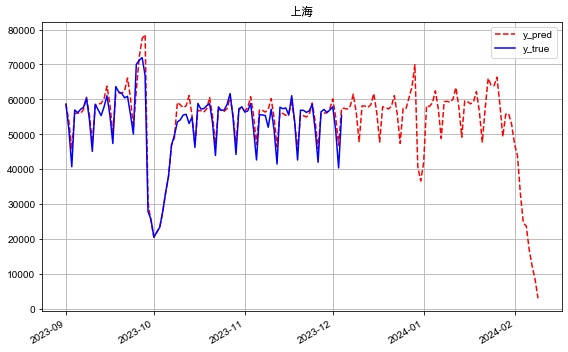

In [23]:
plot_fcst(pred_df.query("ds >= '2023-09-01'"), city_name = '上海')

### 比率类指标预测：以配对率为例

In [24]:
df['y'] = df['matched_order_num']/df['order_num']

10:12:31 - cmdstanpy - INFO - Chain [1] start processing
10:12:36 - cmdstanpy - INFO - Chain [1] done processing


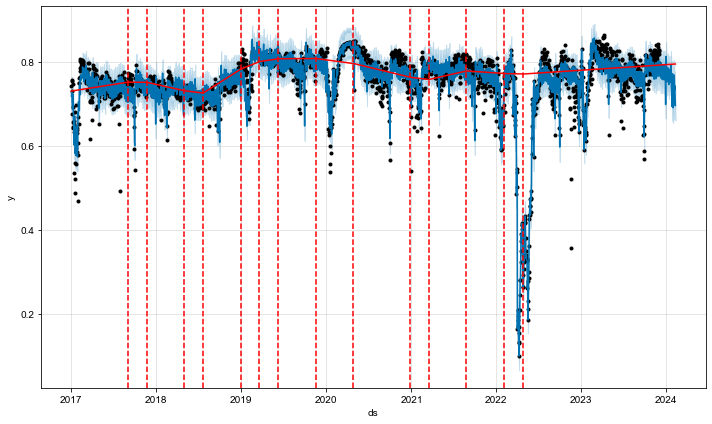

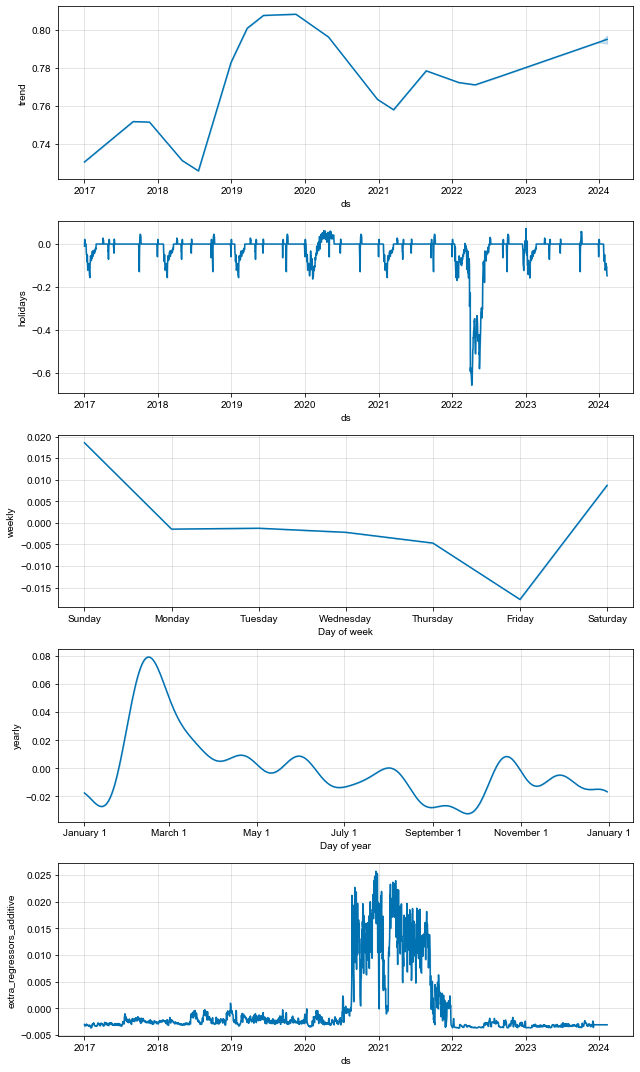

In [25]:
pm_pred = prophet_obj(
    model_df = df,
    pf_params = {
        'seasonality_mode': 'additive', ## 季节模式，数量类指标如果取log就用加法，否则用乘法
        'interval_width': 0.8,
        'holidays': pd.concat([holidays, detected_covid_dates], ignore_index = True),
        'daily_seasonality': False
    },
    default_training_start_dt = '2017-01-01', ## 视情况而定，如果早期数据噪音较大，则可考虑剔除
    default_training_end_dt = jumpoff_date, ## 对于测试来说，training_end_dt不重要
    if_log = False, ### 比率类指标不取log
    extra_reg_lst = ['subsidy_rate']
)

### 预测
pred_df = pm_pred.predict(
    jump_off_date = jumpoff_date,
    fcst_stt_date = fcst_start_date,
    fcst_end_date = fcst_end_date,
    default_reg = 'Auto',
    if_plot = True, ## 是否将时序decompose结果打印
)

### 校正
calib = ratio_calib(adj_level = 'm') ### 校准方式为比率校准，校准强度为中等
pred_df = calib.adj_fcst(pred_df)

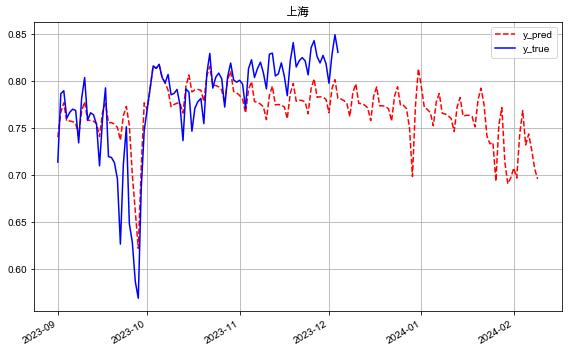

In [26]:
plot_fcst(pred_df.query("ds >= '2023-09-01'"), city_name = '上海')